# Single-cell experiment

In [105]:
import torch
import torch.nn as nn
import torchvision
import torch.distributions as TD

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

from tqdm import tqdm
import wandb
import os
import sys 
sys.path.append("../EnergyGuidedBarycenters/")
from src.utils import Config, Distrib2Sampler, plot_barycenter_map_in_data_space
from src.eot_utils import computePotGrad, evaluating
from src.eot import sample_langevin_batch
from src.dgm_utils.statsmanager import StatsManager, StatsManagerDrawScheduler
from src.cost import cond_score, cost_l2_grad_y
from src.distributions import DatasetSampler
from src.resnet2 import  ResNet_D, weights_init_D

from typing import Callable, Tuple, Union
from sklearn.metrics.pairwise import pairwise_distances

## 1. Setup

In [505]:
SETUP = 1
DIM = 1000
EPS = 0.01
RSI = 4

In [506]:
setup2vals = {
    0: (2, 4, 3),
    1: (3, 7, 4)
}

alphas = {
    0: [0.5,0.5],
    1: [0.75,0.25]
}

dim2lr = {
    50: 5e-4,
    100: 5e-4,
    1000: 5e-4
}

dim2epochs = {
    50: 50,
    100: 50,
    1000: 50
}

rsi2seed = {
    0: 42,
    1: 43,
    2: 44,
    3: 45,
    4: 46
}

dim2hiddens = {
    50: [256, 256, 256],
    100: [256, 256, 256],
    1000: [2048, 1024, 512]
}


## 2. Create Config

In [519]:
CONFIG = Config()
CONFIG.DIM = DIM
CONFIG.EPS = EPS
CONFIG.SETUP = SETUP
CONFIG.RSI = RSI
CONFIG.SEED = rsi2seed[RSI]
CONFIG.DEVICE = 'cuda'

CONFIG.CLIP_GRADS_NORM = False
CONFIG.ALPHAS_BARYCENTER = alphas[SETUP] # loss += alpha * (pos_out ** 2 + neg_out ** 2)
CONFIG.HREG = CONFIG.EPS
CONFIG.BATCH_SIZE = 1024
CONFIG.EPOCHS = dim2epochs[CONFIG.DIM]
CONFIG.LR = dim2lr[CONFIG.DIM]
CONFIG.BASIC_NOISE_VAR = 2.0
CONFIG.BETAS = (0.2, 0.99)
 

CONFIG.LANGEVIN_THRESH = None
CONFIG.LANGEVIN_SAMPLING_NOISE = 0.05
CONFIG.ENERGY_SAMPLING_ITERATIONS = 1000
CONFIG.LANGEVIN_DECAY = 1.0
CONFIG.LANGEVIN_SCORE_COEFFICIENT = 1.0
CONFIG.LANGEVIN_COST_COEFFICIENT = CONFIG.LANGEVIN_SAMPLING_NOISE ** 2
CONFIG.ENERGY_SAMPLING_STEP = 1.0
CONFIG.SPECTRAL_NORM_ITERS = 0
CONFIG.REFERENCE_DATA_NOISE_SIGMA = 0.00
CONFIG.P_SAMPLE_BUFFER_REPLAY = 0.95
CONFIG.ENERGY_SAMPLING_NO_PROJECT_DATA = True
 
DEVICE = CONFIG.DEVICE
DIM = CONFIG.DIM

## 3. Data preprocessing

In [520]:
class Sampler:
    def __init__(
        self, device='cuda',
    ):
        self.device = device
    
    def sample(self, bs):
        pass
    

class TensorSampler(Sampler):
    def __init__(self, tensor, device='cuda'):
        super(TensorSampler, self).__init__(device)
        self.tensor = torch.clone(tensor).to(device)
        
    def sample(self, bs):
        assert bs <= self.tensor.shape[0]
        
        ind = torch.tensor(np.random.choice(np.arange(self.tensor.shape[0]), size=bs, replace=False), device=self.device)
        return torch.clone(self.tensor[ind]).detach().to(self.device)

In [521]:
DAY_START, DAY_END, DAY_EVAL = setup2vals[CONFIG.SETUP]
DATA_DIR = '../EnergyGuidedBarycenters_/data_sc/'
data = {}
for day in [2, 3, 4, 7]:
    data[day] = np.load(os.path.join(DATA_DIR, f"full_cite_pcas_{DIM}_day_{day}.npy"))

In [522]:
eval_data = data[DAY_EVAL]
start_data = data[DAY_START]
end_data = data[DAY_END]

constant_scale = np.concatenate([start_data, end_data, eval_data]).std(axis=0).mean()

eval_data_scaled = eval_data/constant_scale
start_data_scaled = start_data/constant_scale
end_data_scaled = end_data/constant_scale

eval_data = torch.tensor(eval_data).float()
start_data = torch.tensor(start_data_scaled).float()
end_data = torch.tensor(end_data_scaled).float()

In [523]:
X_sampler = TensorSampler(torch.tensor(start_data).float(), device=DEVICE)
Y_sampler = TensorSampler(torch.tensor(end_data).float(), device=DEVICE)

<ipython-input-523-ba27e87b29dd>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_sampler = TensorSampler(torch.tensor(start_data).float(), device=DEVICE)
<ipython-input-523-ba27e87b29dd>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_sampler = TensorSampler(torch.tensor(end_data).float(), device=DEVICE)


In [524]:
data_samplers = []
data_samplers.append(X_sampler)
data_samplers.append(Y_sampler)

## 4.Model

In [525]:
class FullyConnectedMLP(nn.Module):

    def __init__(
        self,
        input_dim,
        hiddens,
        output_dim,
        activation_gen=lambda: nn.ReLU(),
        sn_iters=0
    ):

        def _SN(module):
            if sn_iters == 0:
                return module
            return spectral_norm(
                module, init=False, zero_bias=False, n_iters=sn_iters)

        assert isinstance(hiddens, list)
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hiddens = hiddens

        model = []
        prev_h = input_dim
        for h in hiddens:
            model.append(_SN(nn.Linear(prev_h, h)))
            model.append(activation_gen())
            prev_h = h
        model.append(_SN(nn.Linear(hiddens[-1], output_dim)))
        self.net = nn.Sequential(*model)

    def forward(self, x):
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)
        return self.net(x).view(batch_size, self.output_dim)

In [526]:
class FullyConnectedMLPwithConfig(nn.Module):

    def __init__(
        self,
        input_dim,
        hiddens,
        output_dim,
        config=None,
        activation_gen=lambda: nn.ReLU(),
        sn_iters=0
    ):
        super().__init__()
        self.potential = FullyConnectedMLP(
            input_dim, hiddens, output_dim, 
            activation_gen=activation_gen, sn_iters=sn_iters)
    
    def forward(self, x):
        return self.potential(x)

In [527]:
f1 = FullyConnectedMLPwithConfig(input_dim=CONFIG.DIM,
                                hiddens=dim2hiddens[CONFIG.DIM],
                                output_dim=1).to(CONFIG.DEVICE)

 
f1_opt = torch.optim.Adam(f1.parameters(), CONFIG.LR, betas=CONFIG.BETAS)

## 5. Training procedure

In [528]:
def sample_langevin_mu_f(
        f: Callable[[torch.Tensor], torch.Tensor], 
        x: torch.Tensor, 
        y_init: torch.Tensor, 
        config: Config
    ) -> torch.Tensor:
    
    def score(y, ret_stats=False):
        return cond_score(f, cost_l2_grad_y, y, x, config, ret_stats=ret_stats)
    
    y, r_t, cost_r_t, score_r_t, noise_norm = sample_langevin_batch(
        score, 
        y_init,
        n_steps=config.ENERGY_SAMPLING_ITERATIONS, 
        decay=config.LANGEVIN_DECAY, 
        thresh=config.LANGEVIN_THRESH, 
        noise=config.LANGEVIN_SAMPLING_NOISE, 
        data_projector=lambda x: x, 
        compute_stats=True)
    
    return y

In [529]:
init_noise_sampler = Distrib2Sampler(TD.Normal(
    torch.zeros(CONFIG.DIM).to('cpu'), 
    torch.ones(CONFIG.DIM).to('cpu') * CONFIG.BASIC_NOISE_VAR))

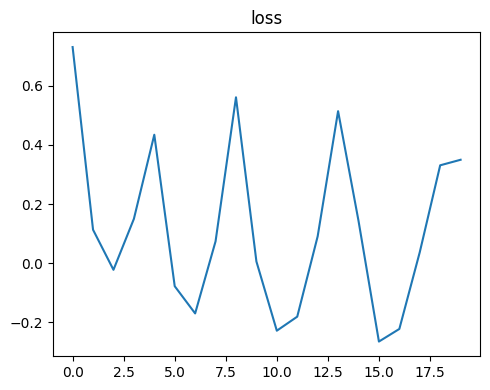

 66%|██████▌   | 33/50 [04:56<02:32,  8.99s/it]


KeyboardInterrupt: 

In [530]:
SMDS = StatsManagerDrawScheduler(StatsManager('loss'), 1, 1, (5, 4), epoch_freq=20)

for step in tqdm(range(CONFIG.EPOCHS)):
     
    f1.train(True)
    X1 = data_samplers[0].sample(CONFIG.BATCH_SIZE).to(CONFIG.DEVICE)
    X2 = data_samplers[1].sample(CONFIG.BATCH_SIZE).to(CONFIG.DEVICE)
    
    Y1_init = init_noise_sampler.sample(CONFIG.BATCH_SIZE).to(CONFIG.DEVICE)
    Y2_init = init_noise_sampler.sample(CONFIG.BATCH_SIZE).to(CONFIG.DEVICE)
    
    with evaluating(f1):
        Y1 = sample_langevin_mu_f(lambda x: f1(x), X1, Y1_init, CONFIG)
        Y2 = sample_langevin_mu_f(lambda x: -f1(x), X2, Y2_init, CONFIG)
        
    loss = CONFIG.ALPHAS_BARYCENTER[0]*f1(Y1).mean() - CONFIG.ALPHAS_BARYCENTER[1]*f1(Y2).mean()
    f1_opt.zero_grad(); loss.backward(); f1_opt.step()
    SMDS.SM.upd('loss', loss.item())
    SMDS.epoch()
    
            

## 6. Evaluation

In [462]:
def ed(x, y):
    Kxx = pairwise_distances(x, x)
    Kyy = pairwise_distances(y, y)
    Kxy = pairwise_distances(x, y)

    m = x.shape[0]
    n = y.shape[0]
    
    c1 = 1 / ( m * (m - 1))
    A = np.sum(Kxx - np.diag(np.diagonal(Kxx)))

    # Term II
    c2 = 1 / (n * (n - 1))
    B = np.sum(Kyy - np.diag(np.diagonal(Kyy)))

    # Term III
    c3 = 1 / (m * n)
    C = np.sum(Kxy)

    # estimate MMD
    mmd_est = -0.5*c1*A - 0.5*c2*B + c3*C
    
    return mmd_est

In [531]:
X = torch.tensor(start_data).float().to(DEVICE)
Y1_init = init_noise_sampler.sample(start_data.shape[0]).to(CONFIG.DEVICE)
with evaluating(f1):
    Y1 = sample_langevin_mu_f(lambda x: f1(x), X, Y1_init, CONFIG)

x = X.cpu()
egbary_samples = Y1.cpu()
eps = torch.tensor(CONFIG.EPS)

predict = torch.sqrt(0.5*0.5*eps)*torch.randn_like(x) + 0.5*x + 0.5*egbary_samples
predict = predict * constant_scale

gt_predict = eval_data
RES = ed(predict.cpu().numpy(), gt_predict.cpu().numpy())

<ipython-input-531-24b57ebf0191>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(start_data).float().to(DEVICE)


In [21]:
file = open(f'../EnergyGuidedBarycenters/data_sc/metrics.txt','a')
file.write(f"dim = {DIM}, setup = {SETUP}, rsi = {RSI}, res = {RES} \n")
file.close()